In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Lambda
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models    
from keras.models import load_model
from sklearn import metrics
#import tensorflow as tf
#import os 
#from os import listdir
#from os.path import isfile, isdir, join
#from sklearn.model_selection import  train_test_split
#from keras.layers.core import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import Flatten
#from sklearn.preprocessing import StandardScaler


Using TensorFlow backend.


In [ ]:
letterList = ["A","B","C","D","E"]

def data_clean(List):
  data_all =pd.DataFrame()
  training=pd.DataFrame()
  testing=pd.DataFrame()
  validation=pd.DataFrame()
  for f in List:
    #data= open(path+"/"+f)
    names = ''.join([f+".xlsx"])
    data = pd.read_excel(names)
    ##修改資料名稱
    data.rename(columns={'Unnamed: 0':'time'}, inplace=True)
    data.rename(columns={'Unnamed: 1':'stock_price'}, inplace=True)
    data.columns = [col.replace('-', '') for col in data.columns]
    ##遠端
    #data.reset_index(inplace=True) 
    #data.rename(columns={'level_0':'time'}, inplace=True)
    #data.rename(columns={'level_1':'stock_price'}, inplace=True)
    ##增加股票代碼
    data['stock_ticker']=pd.DataFrame(np.repeat(ord(f.lower()) - 96,data.shape[0],axis=0))
    columns = data.columns
    data = data.reindex(columns=columns)
    ##lag1期
    #data["lag_stock_price"]=data["stock_price"].shift(1)
    ##挑出要使用的變數
    data=data[['time', 'stock_price', 'stock_ticker','  DIVIDEND YIELD','  ASK PRICE', '  BID PRICE', '  PRICE HIGH', '  PRICE LOW']]
    ##imputation using previous value 
    data=data.fillna(method='pad')##filling the missing data with previous one
    ##拆分資料
    train=len(data)-400
    test_len=len(data)-51
    ##train
    tx_data=data.iloc[:train,:]
    ##validation
    validation_data=data.iloc[train:test_len,:]
    ##test
    tex_data=data.iloc[test_len:,:]
    ##train apppend
    training = training.append(tx_data)
    ##validation append
    validation= validation.append(validation_data)
    ##test append
    testing = testing.append(tex_data)
    ##all data set append 
    data_all = data_all.append(data) 
  return data_all ,testing,training,validation

In [ ]:
##by the stock ticker to splite data 

def splite_data(data):
  A=data[data[1]==0.0]
  B=data[data[1]==1.0]
  C=data[data[1]==2.0]
  D=data[data[1]==3.0]
  E=data[data[1]==4.0]
  return A, B, C, D, E  

In [ ]:
##gen  dataset
data_all,testing,training,validations=data_clean(letterList)

In [ ]:
##check the data don't have null
data_all.isnull().sum()

##visualize
#fig, axes = plt.subplots(2,3)
#plt.figure()
#plt.plot(training['time'],training['stock_price'])
#plt.plot(training['time'],training['  DIVIDEND YIELD'])
#plt.plot(training['time'],training['  BID PRICE'])
#plt.plot(training['time'],training['  PRICE HIGH'])
#plt.plot(training['time'],training['  PRICE LOW'])
#plt.plot(training['time'],training['  ASK PRICE'])
#plt.title('stock price history')
#plt.ylabel('Price (TWD)')
#plt.xlabel('Days')
#plt.legend(['stock_price','DIVIDEND YIELD','BID PRICE','PRICE HIGH','PRICE LOW','ASK PRICE'], loc='upper left')
#plt.show()


time                0
stock_price         0
stock_ticker        0
  DIVIDEND YIELD    0
  ASK PRICE         0
  BID PRICE         0
  PRICE HIGH        0
  PRICE LOW         0
dtype: int64

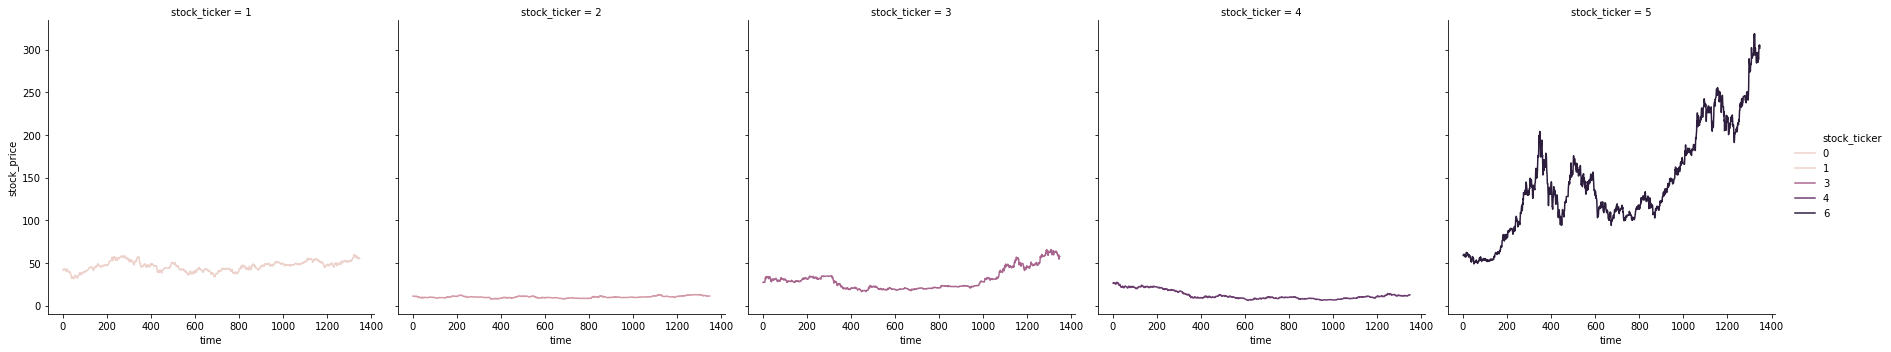

In [ ]:
##visualize
# plot lines 
sns.relplot(x="time", y="stock_price",kind="line",  
            col='stock_ticker',
            hue='stock_ticker',
            data=training)

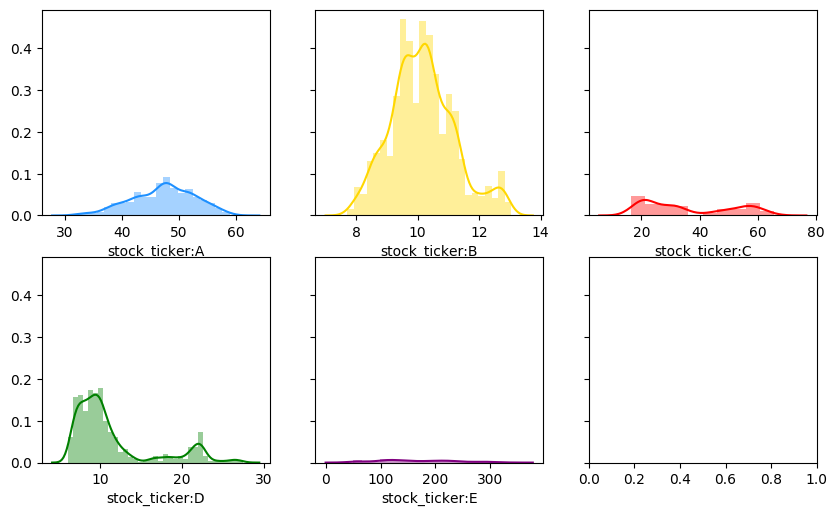

In [ ]:
x_1=data_all.loc[data_all['stock_ticker']==1, ['stock_price']]
x_2=data_all.loc[data_all['stock_ticker']==2, ['stock_price']]
x_3=data_all.loc[data_all['stock_ticker']==3, ['stock_price']]
x_4=data_all.loc[data_all['stock_ticker']==4, ['stock_price']]
x_5=data_all.loc[data_all['stock_ticker']==5, ['stock_price']]
y=data_all.loc[data_all['stock_ticker']==1, ['time']]

# plot density
fig, axes = plt.subplots(2, 3, figsize=(10, 6), sharey=True, dpi=100)
sns.distplot(x_1 , color="dodgerblue", ax=axes[0][0], axlabel='stock_ticker:A')
sns.distplot(x_2 , color="gold", ax=axes[0][1], axlabel='stock_ticker:B')
sns.distplot(x_3 , color="red", ax=axes[0][2], axlabel='stock_ticker:C')
sns.distplot(x_4 , color="green", ax=axes[1][0], axlabel='stock_ticker:D')
sns.distplot(x_5 , color="purple", ax=axes[1][1], axlabel='stock_ticker:E')

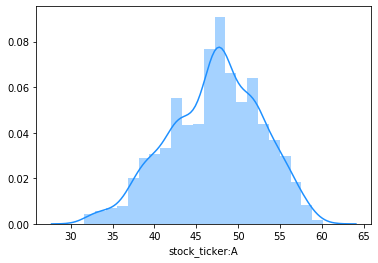

In [ ]:
x_1=data_all.loc[data_all['stock_ticker']==1, ['stock_price']]
x_2=data_all.loc[data_all['stock_ticker']==2, ['stock_price']]
x_3=data_all.loc[data_all['stock_ticker']==3, ['stock_price']]
x_4=data_all.loc[data_all['stock_ticker']==4, ['stock_price']]
x_5=data_all.loc[data_all['stock_ticker']==5, ['stock_price']]
y=data_all.loc[data_all['stock_ticker']==1, ['time']]
sns.distplot(x_1 , color="dodgerblue", axlabel='stock_ticker:A')

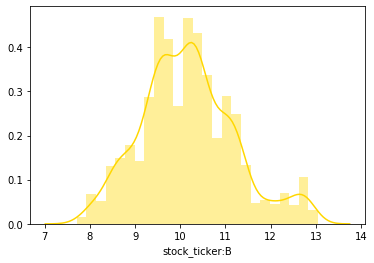

In [ ]:
sns.distplot(x_2 , color="gold", axlabel='stock_ticker:B')

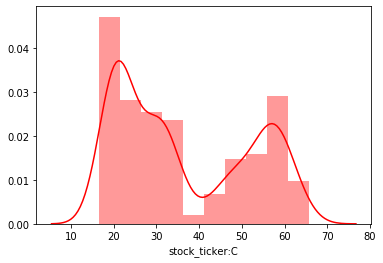

In [ ]:
sns.distplot(x_3 , color="red", axlabel='stock_ticker:C')

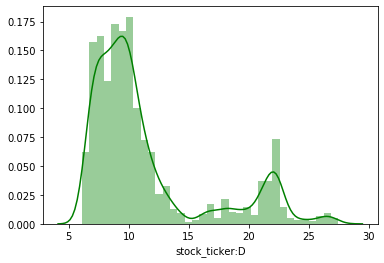

In [ ]:
sns.distplot(x_4 , color="green", axlabel='stock_ticker:D')

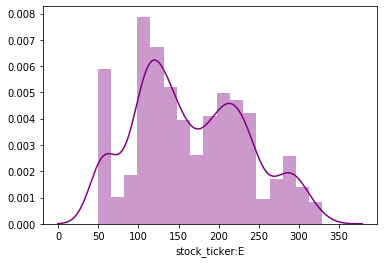

In [ ]:
sns.distplot(x_5 , color="purple", axlabel='stock_ticker:E')

In [ ]:
# load dataset
#os.chdir('D:\\Python\\PYTHON_DATA')
#training = read_csv('training.csv', header=0, index_col=0)


training.index =training[ 'time']
#training.fillna(0, inplace=True) #fill na using 0
training=training.drop("time",1)
values = training.values
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])


testing.index=testing['time']
#testing.fillna(0, inplace=True) #fill na using 0
testing=testing.drop("time",1)
values_testing = testing.values
# integer encode direction
encoder = LabelEncoder()
values_testing[:,1] = encoder.fit_transform(values_testing[:,1])



validations.index =validations['time']
#validations.fillna(0, inplace=True) #fill na using 0
validations=validations.drop("time",1)
values_validation = validations.values
# integer encode direction
encoder = LabelEncoder()
values_validation[:,1] = encoder.fit_transform(values_validation[:,1])


In [ ]:
# ensure all data is float
# training 
values = values.astype('float32')
# testing 
values_testing = values_testing.astype('float32')
# validation 
values_validation = values_validation.astype('float32')

# normalize features
# training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


# validation
scaler_validation = MinMaxScaler(feature_range=(0, 1))
scaled_validation = scaler_validation.fit_transform(values_validation)

# testing 
scaler_testing = MinMaxScaler(feature_range=(0, 1))
scaled_testing = scaler_testing.fit_transform(values_testing)

In [ ]:
# split into input and outputs
train_X ,train_y=scaled[:,1:7], scaled[:,0]
validation_X,validation_y= scaled_validation[:,1:7], scaled_validation[:,0]
test_X, test_y = scaled_testing[:,1:7], scaled_testing[:,0]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0],1,6))
test_X = test_X.reshape((test_X.shape[0],1,6))
validation_X = validation_X.reshape((validation_X.shape[0], 1,6))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape,validation_X.shape,validation_y.shape)

(255, 6) 255 (255,)
(6735, 1, 6) (6735,) (255, 1, 6) (255,) (1745, 1, 6) (1745,)


In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(1,6), return_sequences=True))
model.add(Lambda(lambda x: x[:, -50:, :]))
model.add(LSTM(50, input_shape=(50, 6), return_sequences=True))
model.add(Dense(50))
model.add(LSTM(50, input_shape=(50, 6), return_sequences=True))
model.add(Dense(50))
model.add(LSTM(50, input_shape=(50,6), return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
# fit network use validation 
history = model.fit(train_X,train_y,epochs=50,batch_size=64,validation_data=(validation_X,validation_y))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6735 samples, validate on 1745 samples
Epoch 1/50





6735/6735 [==============================] - 5s 683us/step - loss: 0.0130 - val_loss: 4.6900e-04
Epoch 2/50
6735/6735 [==============================] - 1s 184us/step - loss: 7.7300e-05 - val_loss: 6.6242e-05
Epoch 3/50
6735/6735 [==============================] - 1s 190us/step - loss: 3.7439e-05 - val_loss: 1.0101e-04
Epoch 4/50
6735/6735 [==============================] - 1s 182us/step - loss: 4.1328e-05 - val_loss: 4.2781e-05
Epoch 5/50
6735/6735 [==============================] - 1s 182us/step - loss: 4.2527e-05 - val_loss: 4.5558e-05
Epoch 6/50
6735/6735 [==============================] - 1s 184us/step - loss: 3.8152e-05 - val_loss: 5.4078e-05
Epoch 7/50
6735/6735 [==============================] - 1s 186us/step - loss: 3.6582e-05 - val_loss: 5.2922e-05
Epoch 8/50
6735/6735 [==============================] - 1s 185us/step 

In [ ]:
##save model(another way using sklearn2pmml)
model.save("LSTM_MODEL.h5")

##load model(another way using sklearn2pmml)
#https://stackoverflow.com/questions/33221331/export-python-scikit-learn-models-into-pmml
model = load_model('LSTM_MODEL.h5')

dict_keys(['val_loss', 'loss'])


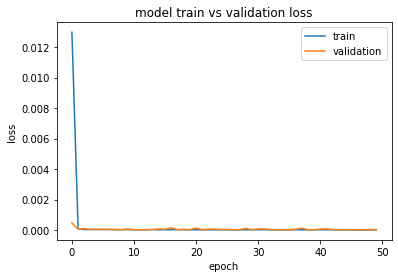

In [ ]:
print(history.history.keys())
#summarize history for loss plt.plot(history.history['loss']) plt.plot(history.history['val_loss']) plt.title('model loss')
##經loss圖看，兩組數據性能應為相似，若兩條線分開則有可能應該提前停止訓練
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
test_X = test_X.reshape((test_X.shape[0], 6))
inv_yhat = concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat= scaler_testing.inverse_transform(inv_yhat)
test_X = test_X.reshape((test_X.shape[0], 6))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler_testing.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler_testing.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE(for total)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.876


In [ ]:
inv_yhat = concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler_testing.inverse_transform(inv_yhat)
inv_y = concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler_testing.inverse_transform(inv_y)

In [ ]:
df = pd.DataFrame(inv_yhat)
df_true = pd.DataFrame(inv_y)
A,B,C,D,E=splite_data(df)
Atrue,Btrue,Ctrue,Dtrue,Etrue=splite_data(df_true)



# calculate RMSE(for individual)
#A company
rmse = sqrt(mean_squared_error(A[0], Atrue[0]))
print('Test A company RMSE: %.3f' % rmse)
#B company
rmse = sqrt(mean_squared_error(B[0], Btrue[0]))
print('Test B company RMSE: %.3f' % rmse)
#C company
rmse = sqrt(mean_squared_error(C[0], Ctrue[0]))
print('Test C company RMSE: %.3f' % rmse)
#D company
rmse = sqrt(mean_squared_error(D[0], Dtrue[0]))
print('Test D company RMSE: %.3f' % rmse)
#E company
rmse = sqrt(mean_squared_error(E[0], Etrue[0]))
print('Test E company RMSE: %.3f' % rmse)

Test A company RMSE: 0.752
Test B company RMSE: 0.159
Test C company RMSE: 1.171
Test D company RMSE: 0.315
Test E company RMSE: 6.269


In [ ]:
##merge predic value and true value to compare accuracy
def conver_data(dataf_true,dataf):
  wide_df=pd.DataFrame()
  wide_df1=pd.DataFrame()
  wide_df2=pd.DataFrame()
  A1=pd.DataFrame()
  B1=pd.DataFrame()
  C1=pd.DataFrame()
  D1=pd.DataFrame()
  E1=pd.DataFrame()

  #dataf.reset_index(inplace=True)
  #dataf.rename(columns={'index':'time1'},inplace=True)
  dataf.rename(columns={0:'stock_price_prediction'},inplace=True)
  dataf.rename(columns={1:'stock_ticker'},inplace=True)

  #dataf_true.reset_index(inplace=True)
  #dataf_true.rename(columns={'index':'time1'},inplace=True)
  dataf_true.rename(columns={0:'stock_price_true'},inplace=True)
  dataf_true.rename(columns={1:'stock_ticker'},inplace=True)
  
  dataf[['stock_price_true']]=dataf_true[['stock_price_true']]
  columns = dataf.columns
  dataf = dataf.reindex(columns=columns)
  dataf1=dataf[['stock_price_prediction','stock_price_true','stock_ticker']]
  A1=dataf1[dataf1['stock_ticker']==0.0]
  B1=dataf1[dataf1['stock_ticker']==1.0]
  C1=dataf1[dataf1['stock_ticker']==2.0]
  D1=dataf1[dataf1['stock_ticker']==3.0]
  E1=dataf1[dataf1['stock_ticker']==4.0]
  
  A1.index = np.arange(0, len(A1))
  A1.reset_index(inplace=True)
  A1.rename(columns={'index':'time'},inplace=True)
  B1.index = np.arange(0, len(A1))
  B1.reset_index(inplace=True)
  B1.rename(columns={'index':'time'},inplace=True)  
  C1.index = np.arange(0, len(A1))
  C1.reset_index(inplace=True)
  C1.rename(columns={'index':'time'},inplace=True)
  D1.index = np.arange(0, len(A1))
  D1.reset_index(inplace=True)
  D1.rename(columns={'index':'time'},inplace=True)
  E1.index = np.arange(0, len(A1))
  E1.reset_index(inplace=True)
  E1.rename(columns={'index':'time'},inplace=True)

  wide_df=A1
  wide_df=wide_df.append(B1, ignore_index = True)
  wide_df=wide_df.append(C1, ignore_index = True)
  wide_df=wide_df.append(D1, ignore_index = True)
  wide_df=wide_df.append(E1, ignore_index = True)
  wide_df1=wide_df[['time', 'stock_price_prediction','stock_ticker']]
  wide_df2=wide_df[['time','stock_price_true','stock_ticker']]
  wide_df1.rename(columns={'stock_price_prediction':'stock_price'},inplace=True)
  wide_df2.rename(columns={'stock_price_true':'stock_price'},inplace=True)
  wide_df1['type']='prediction'
  wide_df2['type']='truth'
  wide_df1=wide_df1.append(wide_df2, ignore_index = True)
  return  wide_df1

In [ ]:
Data_all=conver_data(df_true,df)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


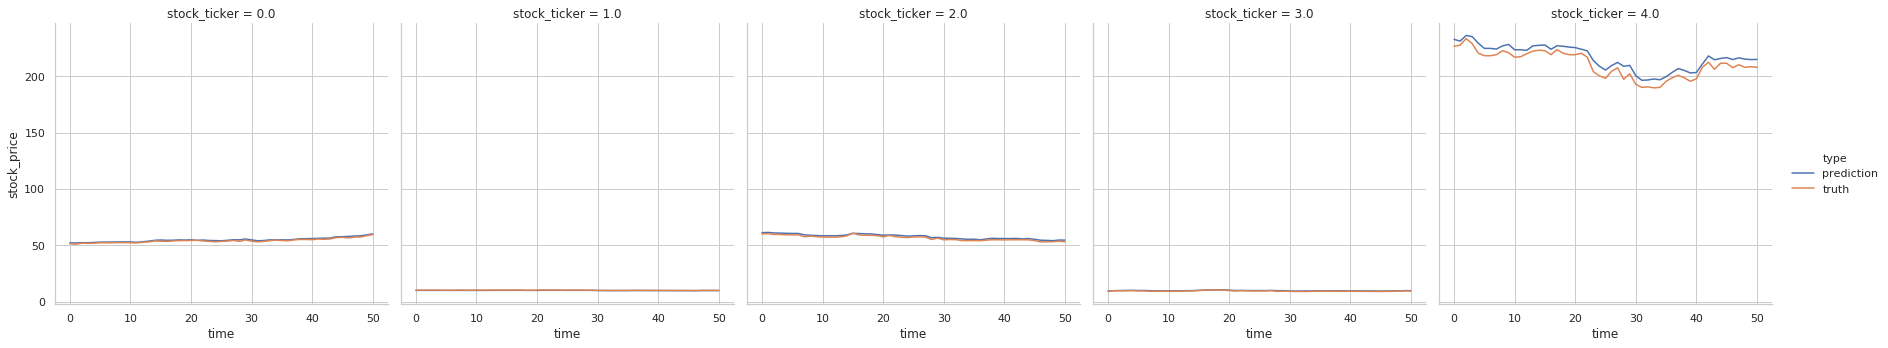

In [ ]:
#sns.lineplot(x="time", y="stock_price",hue='type',data=Data_all,err_style="bars",style="stock_ticker",sizes=(20,15))
sns.set(style="whitegrid")
g=sns.relplot(x="time", y="stock_price",kind="line",  
            hue='type',
            col="stock_ticker",
            data=Data_all)

In [ ]:
##def conditions(data2):
    #if  (data2['percent_change_stock_price'] >(data2["mean_stock_price"]+data2["sd_stock_price"])):
       # return  1
    #elif (data2['percent_change_stock_price'] >=(data2["mean_stock_price"]-data2["sd_stock_price"])):
       # return  0
    #else: 
        #return -1

In [ ]:
##算出各股50天情形
def  gen_percent_change_stock_price(data,data2):
  data["lag_stock_price"]=data[0].shift(1)
  ##算出平均、sd、ercent_change_stock_price
  data['percent_change_stock_price']= (data[0]-data["lag_stock_price"])/data["lag_stock_price"]
  data["mean_stock_price"]=data['percent_change_stock_price'].mean()
  data["sd_stock_price"]=data['percent_change_stock_price'].std()

  data2["lag_stock_price"]=data2[0].shift(1)
  data2['percent_change_stock_price']= (data2[0]-data2["lag_stock_price"])/data2["lag_stock_price"]
  data2['mean_stock_price']=data["mean_stock_price"]
  data2['sd_stock_price']=data["sd_stock_price"]
  return data, data2


def conditions_to_determine_classification(data2):
    if  (data2['percent_change_stock_price'] >(data2["mean_stock_price"]+data2["sd_stock_price"])):
        return  1
    elif (data2['percent_change_stock_price'] >=(data2["mean_stock_price"]-data2["sd_stock_price"])):
        return  0
    else: 
        return -1

##generate the  percent change  stock price        
A_TRUE,class_A=gen_percent_change_stock_price(Atrue,A)
B_TRUE,class_B=gen_percent_change_stock_price(Btrue,B)
C_TRUE,class_C=gen_percent_change_stock_price(Ctrue,C)
D_TRUE,class_D=gen_percent_change_stock_price(Dtrue,D)
E_TRUE,class_E=gen_percent_change_stock_price(Etrue,E)

##gen the classification
class_A['Class'] = class_A.apply(conditions_to_determine_classification, axis=1)
class_B['Class'] = class_B.apply(conditions_to_determine_classification, axis=1)
class_C['Class'] = class_C.apply(conditions_to_determine_classification, axis=1)
class_D['Class'] = class_D.apply(conditions_to_determine_classification, axis=1)
class_E['Class'] = class_E.apply(conditions_to_determine_classification, axis=1)

##gen the classification
A_TRUE['Class'] = A_TRUE.apply(conditions_to_determine_classification, axis=1)
B_TRUE['Class'] = B_TRUE.apply(conditions_to_determine_classification, axis=1)
C_TRUE['Class'] = C_TRUE.apply(conditions_to_determine_classification, axis=1)
D_TRUE['Class'] = D_TRUE.apply(conditions_to_determine_classification, axis=1)
E_TRUE['Class'] = E_TRUE.apply(conditions_to_determine_classification, axis=1)




##export data using excel
class_A.to_excel('class_A.xlsx')
class_B.to_excel('class_B.xlsx')
class_C.to_excel('class_C.xlsx')
class_D.to_excel('class_D.xlsx')
class_E.to_excel('class_E.xlsx')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [ ]:
##accuracy、precision、recall、f1-score

##A compnay
# Print the confusion matrix
print('A_COMPANY \n\n Confusion Matrix\n',metrics.confusion_matrix(A_TRUE.iloc[1:,11], class_A.iloc[1:,11]))
# Print the precision and recall, among other metrics
print(metrics.classification_report(A_TRUE.iloc[1:,11], class_A.iloc[1:,11], digits=3))

##B compnay
# Print the confusion matrix
print('\n\n B_COMPANY \n\n Confusion Matrix\n',metrics.confusion_matrix(B_TRUE.iloc[1:,11], class_B.iloc[1:,11]))
# Print the precision and recall, among other metrics
print(metrics.classification_report(B_TRUE.iloc[1:,11], class_B.iloc[1:,11], digits=3))

##C compnay
# Print the confusion matrix
print('\n\n C_COMPANY \n\n Confusion Matrix\n',metrics.confusion_matrix(C_TRUE.iloc[1:,11], class_C.iloc[1:,11]))
# Print the precision and recall, among other metrics
print(metrics.classification_report(C_TRUE.iloc[1:,11], class_C.iloc[1:,11], digits=3))

##D compnay
# Print the confusion matrix
print('\n\n D_COMPANY \n\n Confusion Matrix\n',metrics.confusion_matrix(D_TRUE.iloc[1:,11], class_D.iloc[1:,11]))
# Print the precision and recall, among other metrics
print(metrics.classification_report(D_TRUE.iloc[1:,11], class_D.iloc[1:,11], digits=3))

##E compnay
# Print the confusion matrix
print('\n\n E_COMPANY \n\n Confusion Matrix\n',metrics.confusion_matrix(E_TRUE.iloc[1:,11], class_E.iloc[1:,11]))
# Print the precision and recall, among other metrics
print(metrics.classification_report(E_TRUE.iloc[1:,11], class_E.iloc[1:,11], digits=3))

A_COMPANY 

 Confusion Matrix
 [[ 2  6  0]
 [ 1 33  0]
 [ 0  4  4]]
              precision    recall  f1-score   support

          -1      0.667     0.250     0.364         8
           0      0.767     0.971     0.857        34
           1      1.000     0.500     0.667         8

    accuracy                          0.780        50
   macro avg      0.811     0.574     0.629        50
weighted avg      0.789     0.780     0.748        50



 B_COMPANY 

 Confusion Matrix
 [[ 1  8  0]
 [ 0 33  0]
 [ 0  7  1]]
              precision    recall  f1-score   support

          -1      1.000     0.111     0.200         9
           0      0.688     1.000     0.815        33
           1      1.000     0.125     0.222         8

    accuracy                          0.700        50
   macro avg      0.896     0.412     0.412        50
weighted avg      0.794     0.700     0.609        50



 C_COMPANY 

 Confusion Matrix
 [[ 2  5  0]
 [ 0 37  2]
 [ 0  3  1]]
              precision    r

In [ ]:
print(class_A,class_B,class_C,class_D,class_E)

            0    1     2  ...  mean_stock_price  sd_stock_price  Class
0   52.274132  0.0  5.32  ...          0.002957        0.009923     -1
1   52.086124  0.0  5.37  ...          0.002957        0.009923      0
2   52.385529  0.0  5.27  ...          0.002957        0.009923      0
3   52.377281  0.0  5.29  ...          0.002957        0.009923      0
4   52.616341  0.0  5.27  ...          0.002957        0.009923      0
5   52.882076  0.0  5.24  ...          0.002957        0.009923      0
6   52.882076  0.0  5.24  ...          0.002957        0.009923      0
7   52.953072  0.0  5.24  ...          0.002957        0.009923      0
8   53.007713  0.0  5.22  ...          0.002957        0.009923      0
9   53.071976  0.0  5.23  ...          0.002957        0.009923      0
10  53.047813  0.0  5.23  ...          0.002957        0.009923      0
11  52.712570  0.0  5.25  ...          0.002957        0.009923      0
12  53.208710  0.0  5.19  ...          0.002957        0.009923      0
13  53

In [ ]:
##算出各股50天情形(WRONG_ORIGINAL)
#def  class_classification(data,data2):
  #data["lag_stock_price"]=data[0].shift(1)
  ##算出平均、sd、ercent_change_stock_price
  #data['percent_change_stock_price']= (data[0]-data["lag_stock_price"])/data["lag_stock_price"]
  #data["mean_stock_price"]=data['percent_change_stock_price'].mean()
  #data["sd_stock_price"]=data['percent_change_stock_price'].std()

  #data2["lag_stock_price"]=data2[0].shift(1)
  #data2['percent_change_stock_price']= (data2[0]-data2["lag_stock_price"])/data2["lag_stock_price"]
  #data2['mean_stock_price']=data["mean_stock_price"]
  #data2['sd_stock_price']=data["sd_stock_price"]
  ##算出漲跌持平class
  #for i in range(1,len(data2)):
    #if  (data2.iloc[i,:]['percent_change_stock_price'] >(data2.iloc[i,:]["mean_stock_price"]+data2.iloc[i,:]["sd_stock_price"])):
        #data2.iloc[i,:]['class'] = 1
    #elif (data2.iloc[i,:]['percent_change_stock_price']>=(data2.iloc[i,:]["mean_stock_price"]-data2.iloc[i,:]["sd_stock_price"])):
        #data2.iloc[i,data2.columns.get_loc('class')] = 0
    #else: 
        #data2.iloc[i,:]['class'] = -1
  #return data2
